In [69]:
from __future__ import print_function
import pyart
import xray
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from mpl_toolkits.basemap.pyproj import Proj
from scipy.interpolate import RegularGridInterpolator
#import scipy.interpolate.griddata
%matplotlib inline

In [177]:
my_data = xray.open_mfdataset('/data/modal/wrfout_d01_2004-12-16_*', concat_dim='Time')
radar = pyart.io.read('/data/xsapr_test_case/XNW130928080000.RAW1HDW')

In [163]:
dx = my_data.DX
dy = my_data.DY
dn = -0.01

lat_0 = 18.
lon_0 = 62.
u_vel = my_data.data_vars['U']
shp = u_vel.shape
time = my_data.data_vars['Times']
lats = my_data.XLAT
lons = my_data.XLONG
levels = np.array([my_data.P.data[0, z, :, :].mean()/100.0 \
                   for z in range(my_data.P.data.shape[1])])
y_array = np.linspace(0, (shp[2]-1)*dx,shp[2])
x_array = np.linspace(0, (shp[3]-1)*dx,shp[3])
n_array = np.linspace(1, (shp[1]-1)*dn,shp[1])

#fake z_array
#zero to 8km

z_array = np.linspace(8000, 0., shp[1])

0.181236 -9.33113


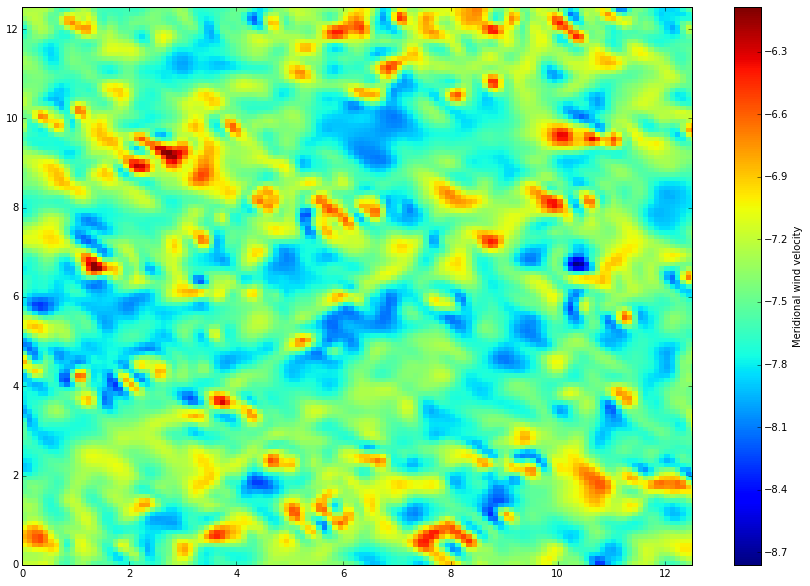

In [164]:
fig = plt.figure(figsize = [15,10])
print(u_vel.data.max(), u_vel.data.min())
plt.pcolormesh(x_array/1000.0, y_array/1000.0, 
               u_vel.data[5, 20, :,:])
cb = plt.colorbar()
plt.ylim([0, 12.5])
plt.xlim([0, 12.5])
cb.set_label('Meridional wind velocity')

<matplotlib.colorbar.Colorbar instance at 0x10d0f7cf8>

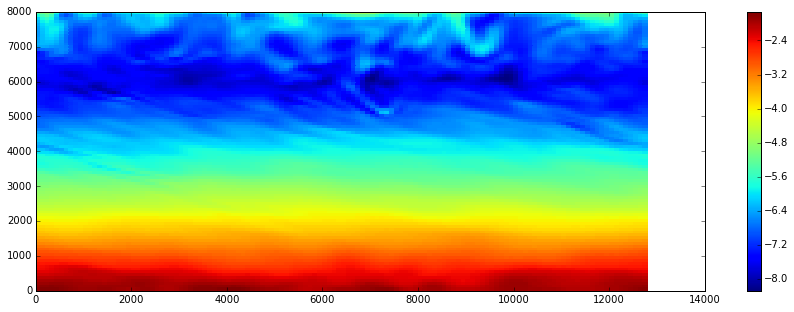

In [52]:
fig = plt.figure(figsize = [15,5])
plt.pcolormesh(x_array, z_array, u_vel.data[5, :, 110,:])
plt.colorbar()


<matplotlib.colorbar.Colorbar instance at 0x1142be998>

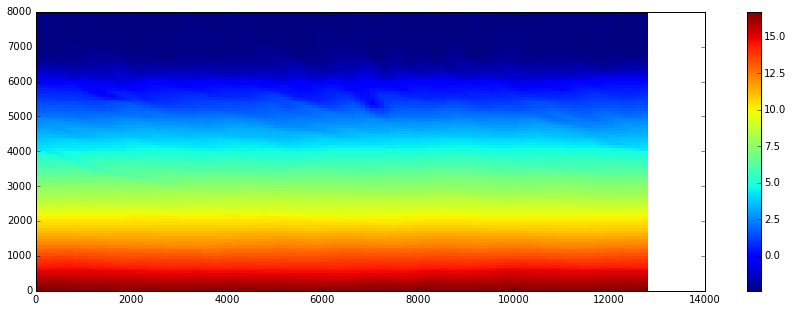

In [64]:
fig = plt.figure(figsize = [15,5])
plt.pcolormesh(x_array, z_array, my_data.variables['T'].data[5, :, 110,:])
plt.colorbar()


In [181]:
want_x = np.ones(10000)*5000.0
want_y = np.ones(10000)*5000.0
want_z = np.linspace(0,4000,10000)
my_interpolating_function = RegularGridInterpolator((z_array[::-1], 
                                                     y_array, x_array), 
                                                    u_vel.values[0,::-1,:,:],
                                                   bounds_error = False,
                                                   fill_value = radar.fields['reflectivity']['_FillValue'])

In [166]:
que = np.array([[want_z[i], want_y[i], want_x[i]] for i in range(len(want_x))])

In [167]:
#doneme = np.array([my_interpolating_function(que[i]) for i in range(len(want_x))])
doneme = my_interpolating_function(que)

(10000,)


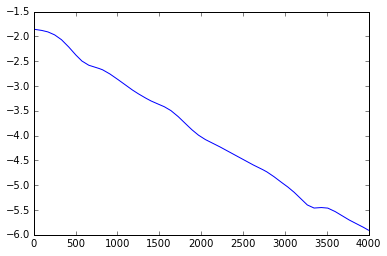

In [168]:
plt.plot(want_z,doneme)
print(doneme.shape)

In [143]:
radar = pyart.io.read('/data/xsapr_test_case/XNW130928080000.RAW1HDW')

In [172]:
rx, ry, rz  = (radar.gate_x['data'].flatten()/5., 
              radar.gate_y['data'].flatten()/5.,
              radar.gate_z['data'].flatten()/5.)

In [173]:
que2 = np.array([[rz[i], ry[i], rx[i]] for i in range(len(rz))])

In [182]:
doneme2 = my_interpolating_function(que2)

In [184]:
my_new_field = doneme2.reshape(radar.fields['reflectivity']['data'].shape)

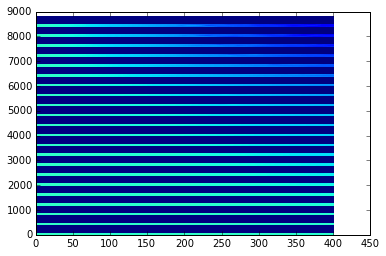

In [186]:
plt.pcolormesh(my_new_field, vmin = -10, vmax = 10)